# Week 4: Shotgun metagenomics - MAG recovery

This week we are turning our attention to analysis of shotgun metagenomic datasets. Unlike amplicon data, metagenomes allow us to get a glimpse into not only composition but also functional potential of microbial communities.

Analysis of real-world shotgun metagenome data is usually time-consuming and very resource-intensive. For this reason, in this week's assignment we will try a simplified analysis of shotgun metagenomes obtained by simulation of paired-end reads from a mock community with known composition. In week 10, we will turn our attention to metagenomic data inference from 16S rRNA gene sequences using PICRUSt2.

We will start by assembling metagenomes using paired-end reads obtained for four samples from a mock community. We have pre-selected some species and generated reads from their genomes - it will be your task to assemble genomes from those reads and try to identify which microorganisms they belong to.

<a id='setup'></a>
## 0. Setup

In [1]:
import pandas as pd
import qiime2 as q2
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

data_dir = 'w4_data'

In [2]:
%%bash -s $data_dir
# Please do NOT modify this cell

mkdir -p "$1"

**Note on file locations:**<br>
File required for today's exercise can be found at two different locations:
- `w4_data` directory (just as every other week so far) - those live directly in your JupyterHub workspace
- `/data/w4_data` directory - this location is only _attached_ to your workspace, i.e. you do not have a copy of those in your workspaace - this is due to large size of some of those files (particularly some databases)

You don't need to worry about those, though. If you create any files yourself, just save them to the `data_dir` directory, as usual. The rest is being taken care of by the code we provided you with.

<a id='assembly'></a>
## 1. Genome assembly
The first step in recovering metagenome-assembled genomes (MAGs) is genome assembly itself. There are many genome assemblers available, two of which you can use through our QIIME 2 plugin - here, we will use [MEGAHIT](https://github.com/voutcn/megahit). MEGAHIT takes short DNA sequencing reads, constructs a simplified [De Bruijn graph](https://en.wikipedia.org/wiki/De_Bruijn_graph), and generates longer contiguous sequences called **contigs**, providing valuable genetic information for the next steps of our analysis.

**Note:** this step will take ~45min so get yourself a coffee!

In [ ]:
! qiime assembly assemble-megahit \
    --i-reads  /data/$data_dir/reads.qza \
    --p-presets meta-sensitive \
    --p-num-cpu-threads 3 \
    --o-contigs $data_dir/contigs.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Once the reads are assembled into contigs, we can use QUAST to evaluate the quality of our assembly. There are many metrics which can be used for that purpose but here we will focus on the two most popular [metrics](https://en.wikipedia.org/wiki/N50,_L50,_and_related_statistics):
- **N50**: represents the contiguity of a genome assembly. It's defined as the length of the contig (or scaffold) at which 50% of the entire genome is covered by contigs of that length or longer - the higher this number, the better.
- **L50**: represents the number of contigs required to cover 50% of the genome's total length - the smaller this number, the better.

In addition to calculating generic statistics like N50 and L50, QUAST will try to identify potential genomes from which the analyzed contigs originated. Alternatively, we can provide it with a set of reference genomes we would like it to run the analysis against. Since we generated the reads from an "artificial" mock community, we will provide the reference sequences for those genomes - this will save us a bit of work and time. Run the following cell to assess the quality of contigs assembled in the previous step: 

In [ ]:
! qiime assembly evaluate-quast \
    --i-contigs $data_dir/contigs.qza \
    --i-references /data/$data_dir/ref-seqs.qza \
    --p-min-contig 500 \
    --p-threads 3 \
    --o-reference-genomes $data_dir/ref-genomes.qza \
    --o-visualization $data_dir/contigs.qzv \
    --o-results-table $data_dir/quast-results.qza

In [3]:
q2.Visualization.load(f"{data_dir}/contigs.qzv")

<visualization: Visualization uuid: a5afab80-aabf-4637-9521-d6111b2d444f>

There are many things to look at in this visualization! Don't worry, it is not our goal to try to understand all of that information, though. Let's focus on the metrics we mentioned above - you will find them on the "QC report" tab, in the colorful table right above the plot. Click on the "Extended report" and use the values you find there to answer the checkpoint questions below.  

<div style="background-color: aliceblue; padding: 10px;">
    
**Checkpoint A**

1. Which of the samples has the highest N50 value?

2. Which of the samples has the highest L50 value?

3. Which of the samples has the highest number of mismatches per 100 kbp?

4. What is the length of the largest contig in _sample2_?

5. In your opinion, which of the samples represents the best assembly? Provide a short justification.
</div>

**Answers Checkpoint A**

1. *sample4* (84797)
2. *sample1* (2758)
3. *sample1* (307.3)
4. 77570 bp
5. Focusing on the two popular metrics, *sample4* represents the best assembly, since it has the lowest L50 and highest N50.

<a id='mapping'></a>
## 2. Read mapping
Before we continue to assembling MAGs, we need to index the contigs obtained in the assembly step and map the original reads to those contigs using that index. This read mapping can then be used by the contig binner to figure out which contigs originated from the same genome and put those together. Execute the two cells below to run the contig indexing and read mapping actions (that should take only a few minutes):  

In [5]:
! qiime assembly index-contigs \
    --i-contigs $data_dir/contigs.qza \
    --p-threads 3 \
    --p-seed 100 \
    --o-index $data_dir/contigs-index.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved SampleData[SingleBowtie2Index % Properties('contigs')] to: w4_data/contigs-index.qza


In [6]:
! qiime assembly map-reads \
    --i-index $data_dir/contigs-index.qza \
    --i-reads /data/$data_dir/reads.qza \
    --p-threads 3 \
    --p-seed 100 \
    --o-alignment-maps $data_dir/reads-to-contigs-aln.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved SampleData[AlignmentMap] to: w4_data/reads-to-contigs-aln.qza


<a id='binning'></a>
## 3. Contig binning
Finally, we are ready to perform contig binning. This process involves categorizing contigs into distinct bins or groups based on their likely origin from different microbial species or strains within a mixed community. Here, we will use the [MetaBAT 2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6662567/) tool, which uses tetranucleotide frequency together with abundance (coverage) information to assign contigs to individual bins. 

In [7]:
! qiime annotate bin-contigs-metabat \
    --i-contigs $data_dir/contigs.qza \
    --i-alignment-maps $data_dir/reads-to-contigs-aln.qza \
    --p-num-threads 3 \
    --p-seed 100 \
    --o-mags $data_dir/mags.qza \
    --o-contig-map $data_dir/contig-map.qza \
    --o-unbinned-contigs $data_dir/unbinned-contigs.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved SampleData[MAGs] to: w4_data/mags.qza
Saved FeatureMap[MAGtoContigs] to: w4_data/contig-map.qza
Saved SampleData[Contigs % Properties('unbinned')] to: w4_data/unbinned-contigs.qza


<a id='mag_qc'></a>
## 4. MAG quality control
The previous steps generated a couple artifacts:
- `mags.qza`: these are our actual MAGS, per sample
- `contig-map.qza`: this is a mapping between MAG IDs and IDs of contigs which belong to a given MAG
- `unbinned-contigs.qza`: these are all the contigs that could not be assign to any particular MAG

Once we have our contigs binned into Metagenome-Assembled Genomes (MAGs), we need to check what the quality of those bins is. There are a couple of diffeernt tools which can be used for this purpose, many of which use the single-copy marker genes to estimate the completeness and purity (or contamination) of the recovered genomes. Here, we will use [BUSCO](https://busco.ezlab.org/) which uses a set of curated ortholog genes to estimate those metrics.

We begin by fetching the required BUSCO database: we know that all species in our samples are strictly bacteria so we can fetch only this lineage to save some space and resources:

In [8]:
! qiime annotate fetch-busco-db \
    --p-lineages bacteria_odb12 \
    --o-db $data_dir/busco-db-bacteria.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved ReferenceDB[BUSCO] to: w4_data/busco-db-bacteria.qza


Next, we use the database we fetched to run BUSCO with our recovered MAGs as input:

In [9]:
! qiime annotate evaluate-busco \
    --i-mags $data_dir/mags.qza \
    --i-db $data_dir/busco-db-bacteria.qza \
    --p-lineage-dataset bacteria_odb12 \
    --p-cpu 3 \
    --o-results $data_dir/busco-results.qza \
    --o-visualization $data_dir/mags.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved BUSCOResults to: w4_data/busco-results.qza
Saved Visualization to: w4_data/mags.qzv


The action above generated a result table and a neat visualization which will allow us to investigate the quality of all of our genomes.

In [5]:
q2.Visualization.load(f"{data_dir}/mags.qzv")

<visualization: Visualization uuid: 099893d5-e1e6-4107-bb46-624407f78705>

<div style="background-color: aliceblue; padding: 10px;">
    
**Checkpoint B**

1. In which of the samples could we recover the most MAGs that are at least 50% complete?

2. Which of the samples has the smallest count of recovered MAGs?

3. What is the best completeness score we were able to achieve across all samples?

4. What is the length of the shortest recovered MAG?How complete is it?

5. Compare the results you got here with the post-assembly quality control. Which of the samples, in your opinion, contains the best MAGs? Do the results correlate with the assembly quality?
</div>

**Answers to Checkpoint B**
1. in *sample4*
2. *sample1*
3. 100%
4. 340518 bp and is 0.9 complete
5. *sample4* contains the best MAGs (has most MAGs with higher completeness and all the MAGs have a low contamination percentage). Those results correlate with the assembly quality but it happens that it's not always the case.

Now that we evaluated the quality of our MAGs, we can use this information to filter out only the best ones. We do not want to continue with MAGs of low quality (not very complete or highly contaminated) as it may lead to incorrect results in the downstream analyses. We want to keep the MAGs which are at least 50% complete and have less than 10% contamination (these are considered to be of medium quality according to the [MIMAG standard](https://doi.org/10.1038/nbt.3893)). We can easily achieve this with the following action:

In [11]:
! qiime annotate filter-mags \
    --i-mags $data_dir/mags.qza \
    --m-metadata-file $data_dir/busco-results.qza \
    --p-where "completeness>50 AND contamination<10" \
    --p-on "mag" \
    --o-filtered-mags $data_dir/mags-filtered.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved SampleData[MAGs] to: w4_data/mags-filtered.qza


<a id='dereplication'></a>
## 5. MAG dereplication
Since our samples were generated from the same mock community (i.e., we know they most likely contain the same set of genomes), we can simplify our MAG collection by performing __dereplication__, similarly to how you do it for 16S amplicon sequences (remember previous week?). To dereplicate our MAGs, we will:
1. compute hash sketches of every genome using [sourmash](https://sourmash.readthedocs.io/en/latest/) - you can think of those sketches as tiny representations of our genomes (_sourmash_ compresses a lot of information into much smaller space)
2. compare all of those sketches (genomes) to one another to generate a matrix of pairwise distances between our MAGs
3. dereplicate the genomes using the distance matrix and a fixed similarity threshold: the last action will simply choose the most complete genome from all of the genomes belonging to the same cluster, given a similarity threshold

In [13]:
! qiime sourmash compute \
    --i-sequence-file $data_dir/mags-filtered.qza \
    --p-ksizes 105 \
    --p-scaled 100 \
    --o-min-hash-signature $data_dir/mags-hashes.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved MinHashSig to: w4_data/mags-hashes.qza


In [14]:
! qiime sourmash compare \
    --i-min-hash-signature $data_dir/mags-hashes.qza \
    --p-ksize 105 \
    --o-compare-output $data_dir/mags-dist.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: w4_data/mags-dist.qza


In [15]:
! qiime annotate dereplicate-mags \
    --i-mags $data_dir/mags-filtered.qza \
    --i-distance-matrix $data_dir/mags-dist.qza \
    --m-metadata-file $data_dir/busco-results.qza \
    --p-metadata-column "completeness" \
    --p-threshold 0.7 \
    --o-dereplicated-mags $data_dir/mags-derep.qza \
    --o-table $data_dir/mags-table-pa.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[MAG] to: w4_data/mags-derep.qza
Saved FeatureTable[PresenceAbsence] to: w4_data/mags-table-pa.qza


The previous step generated two artifacts:
- `mags-derep.qza` containing all the dereplicated MAGs
- `mags-table-pa.qza` containing a presence-absence table showing which of those MAGs was found in which sample

To conclude this exercise, let's try to visualize the table using a heatmap:

In [6]:
pa_table = q2.Artifact.load(f"{data_dir}/mags-table-pa.qza").view(pd.DataFrame)

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


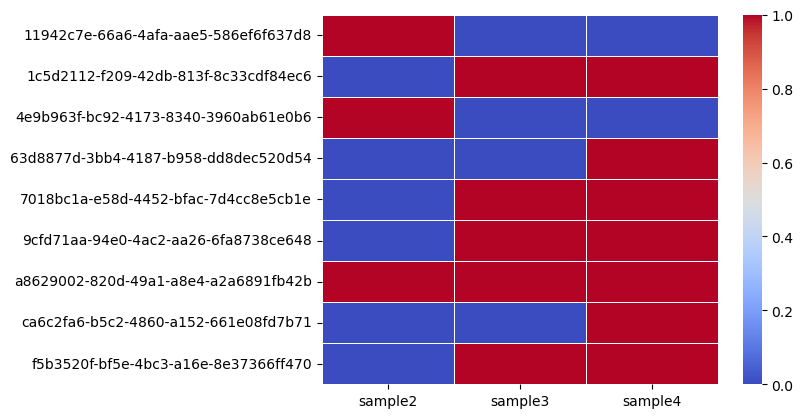

In [7]:
sns.heatmap(pa_table.T, cmap='coolwarm', linewidths=0.5);

<div style="background-color: aliceblue; padding: 10px;">
    
**Checkpoint C**
    
Do you see how sample 4 contains most of the MAGs we recovered? Can you think of a reason why sample 1 is not shown here?
</div>

**Answer to Checkpoint C**
*sample4* has the most recovered MAGs, as it's shown on the previous table having the most red boxes (meaning the MAG is present in the sample). *sample1* had no MAGs with completeness over 50%, so it was removed in the quality filtering step.